# 1. Data Preprocessing


In [4]:
import glob
import scipy.io as sio
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm


In [5]:
image_file_names = [g for g in glob.glob("data/AFLW2000/*.jpg")]
annotation_file_names = [g for g in glob.glob("data/AFLW2000/*.mat")]


images = []
annotations = []


subset = 2000

for i, (iname, aname) in tqdm(enumerate(zip(image_file_names[:subset], annotation_file_names[:subset]))):
    # Read image in BGR format
    im = cv2.imread(iname)

    # Read points in, use only selected landmarks
    points = sio.loadmat(aname)["pt2d"]                                             # Read in points
    # Right Eye, Left Eye, Nose, Right Corner Mouth, Left Corner Mouth, Chin
    POINT_INDICES = [7, 10, 14, 17, 19, 20]                                            
    x, y = np.take(points[0], POINT_INDICES), np.take(points[1], POINT_INDICES)     # Select only chosen points

    # Append input image and output points to respective lists
    images.append(im)
    pts_out = np.vstack((x ,y))
    annotations.append(pts_out)

    # Plot points and images in BGR
    # plt.figure()
    # plt.scatter(x, y, marker="1")
    # plt.imshow(im[:,:,::-1])



images, annotations = np.array(images), np.array(annotations)
print(images.shape, annotations.shape)


2000it [00:09, 207.72it/s]


(2000, 450, 450, 3) (2000, 2, 6)


In [6]:
annotations = annotations.reshape(2000, 12)
print(images.shape, annotations.shape)

np.save("images.npy", images)
np.save("annotations.npy", annotations)

(2000, 450, 450, 3) (2000, 12)


# 2. Data Loading

In [48]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

images, annotations = np.load("images.npy"), np.load("annotations.npy")        
images, annotations = torch.Tensor(images), torch.Tensor(annotations)

images /= 255
images -= 0.5

annotations /= 450

train_dataset = TensorDataset(images[:1250], annotations[:1250])
val_dataset = TensorDataset(images[1250:1750], annotations[1250:1750])
test_dataset = TensorDataset(images[1750:], annotations[1750:])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [10]:
class CNNModel(nn.Module):

    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        torch.nn.init.kaiming_normal_(self.conv1.weight)
        self.conv2 = nn.Conv2d(16, 32, 5)
        torch.nn.init.kaiming_normal_(self.conv2.weight)
        self.conv3 = nn.Conv2d(32, 64, 5)
        torch.nn.init.kaiming_normal_(self.conv3.weight)
        self.conv4 = nn.Conv2d(64, 32, 5)
        torch.nn.init.kaiming_normal_(self.conv4.weight)
        self.conv5 = nn.Conv2d(32, 16, 5)
        torch.nn.init.kaiming_normal_(self.conv5.weight)
        
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(32)
        self.bn5 = nn.BatchNorm2d(16)

        self.fc1 = nn.Linear(1600, 512)
        torch.nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(512, 256)
        torch.nn.init.kaiming_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(256, 12)
        torch.nn.init.kaiming_normal_(self.fc3.weight)

    def forward(self, x):     
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), (2, 2))
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), (2, 2))
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), (2, 2))
        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), (2, 2))
        x = F.max_pool2d(F.relu(self.bn5(self.conv5(x))), (2, 2))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))


        return x
    

In [163]:
epochs = 25
learning_rate = 1
weight_decay = 0.001
batch_size = 16
momentum = 0.05

model = CNNModel()  #making an instance of the network
model = model.cuda()
optim = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay=weight_decay, momentum=momentum)  #model.paramters() gives all the trainable paramters.
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr = learning_rate, epochs=epochs, steps_per_epoch=len(train_dataloader))
loss_function = nn.MSELoss()

global_train_loss = []
global_val_loss = []

for epoch in range(epochs):
    local_train_loss = []
    local_val_loss = []
    
    model.train()
    for idx, batch in enumerate(train_dataloader):
        # Get inputs, ground truth outputs
        im, pts = batch[0].cuda(), batch[1].cuda()
        # Reorient channels to be before height and width
        im = im.permute(0, 3, 1, 2)
        
        # Feed forward, compute loss
        pts_out = model(im)
        loss = loss_function(pts_out, pts)
        local_train_loss.append(loss.item())

        # Backprop, step optimizer
        optim.zero_grad()
        loss.backward()  
        optim.step()
        scheduler.step()
    
    
    model.eval()
    for idx, batch in enumerate(val_dataloader):
        with torch.no_grad():
            im, pts = batch[0].cuda(), batch[1].cuda()
            im = im.permute(0, 3, 1, 2)
            
            pts_out = model(im)
            loss = loss_function(pts_out, pts)
            local_val_loss.append(loss.item())
    
    global_train_loss.append(sum(local_train_loss)/(len(local_train_loss) * batch_size))
    global_val_loss.append(sum(local_val_loss)/(len(local_val_loss) * batch_size))

    if epoch%1==0:
        print("Epoch : [{}/{}], Train loss: {}, Val loss: {}".format(epoch+1, epochs, global_train_loss[-1], global_val_loss[-1]))


Epoch : [1/25], Train loss: 0.0019681348334231615, Val loss: 0.0011253044594923267
Epoch : [2/25], Train loss: 0.00084268683924994, Val loss: 0.0009909361897371127
Epoch : [3/25], Train loss: 0.0006964021072062794, Val loss: 0.0010146834538318217
Epoch : [4/25], Train loss: 0.0006761633199005965, Val loss: 0.0009641575870773522
Epoch : [5/25], Train loss: 0.0006512880223638178, Val loss: 0.0010421293109175167
Epoch : [6/25], Train loss: 0.0006575735232091356, Val loss: 0.0008821061223898141
Epoch : [7/25], Train loss: 0.0006701250336224307, Val loss: 0.0008854817838255258
Epoch : [8/25], Train loss: 0.0006881155408152579, Val loss: 0.001028655954542046
Epoch : [9/25], Train loss: 0.0006335814935862547, Val loss: 0.000824328782982775
Epoch : [10/25], Train loss: 0.000631970771930263, Val loss: 0.0009547116223984631
Epoch : [11/25], Train loss: 0.0006785553917244572, Val loss: 0.0009310937025475141
Epoch : [12/25], Train loss: 0.0006602172670912446, Val loss: 0.0010940680053863616
Epoch 

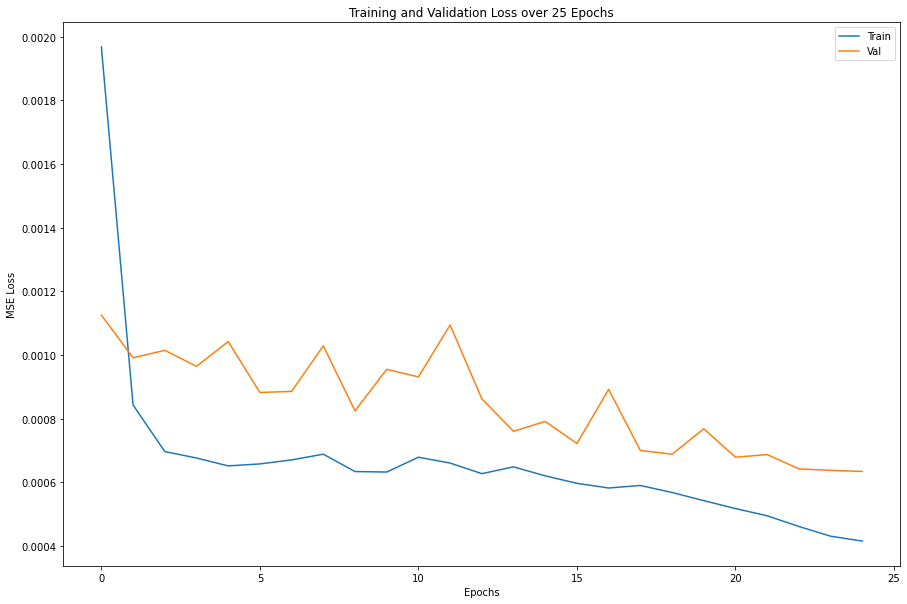

In [221]:
import matplotlib.pyplot as plt

torch.save(model.state_dict(), "model.pth")


plt.figure(figsize=(15,10))
plt.title('Training and Validation Loss over 25 Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.plot(global_train_loss, label='Train')
plt.plot(global_val_loss, label='Val')
plt.legend()

In [166]:
torch.save(model.state_dict(), 'model.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


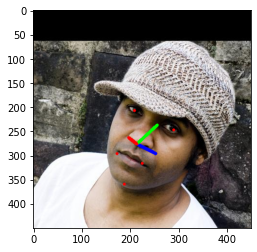

In [87]:
im, pts = test_dataset[0]


def plotImage(im, pts):
    
    def rot_params_rv(rvecs):
        from math import pi,atan2,asin
        R = cv2.Rodrigues(rvecs)[0]
        roll = 180*atan2(-R[2][1], R[2][2])/pi
        pitch = 180*asin(R[2][0])/pi
        yaw = 180*atan2(-R[1][0], R[0][0])/pi
        rot_params= [roll,pitch,yaw]
        return rot_params

    im, pts = (im.numpy() + 0.5), pts.numpy() * 450
    size = im.shape

    x, y = pts[:6], pts[6:]
    image_points = np.array([
        (x[2], y[2]), # Nose Tip
        (x[5], y[5]), # Chin
        (x[1], y[1]), # Left Eye
        (x[0], y[0]), # Right Eye
        (x[4], y[4]), # Left Mouth Corner
        (x[3], y[3]), # Right Mouth Corner
    ])

    model_points = np.array([
        (0.0, 0.0, 0.0),             # Nose tip
        (0.0, -330.0, -65.0),        # Chin
        (-225.0, 170.0, -135.0),     # Left eye left corner
        (225.0, 170.0, -135.0),      # Right eye right corne
        (-150.0, -150.0, -125.0),    # Left Mouth corner
        (150.0, -150.0, -125.0)      # Right mouth corner
    ])


    focal_length = size[1]
    center = (size[1]/2, size[0]/2)
    camera_matrix = np.array(
                             [[focal_length, 0, center[0]],
                             [0, focal_length, center[1]],
                             [0, 0, 1]], dtype = "double"
                             )

    dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
    (success, rotation_vector, translation_vector) = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)
    
    rot_params = rot_params_rv(rotation_vector)
        
    (nose_end_point2Dx, jacobian) = cv2.projectPoints(np.array([(0.0, 0.0, 200.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)
    (nose_end_point2Dy, jacobian) = cv2.projectPoints(np.array([(0.0, 200.0, 0.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)
    (nose_end_point2Dz, jacobian) = cv2.projectPoints(np.array([(200.0, 0.0, 0.0)]), rotation_vector, translation_vector, camera_matrix, dist_coeffs)


    for p in image_points:
        im = cv2.circle(im, (int(p[0]), int(p[1])), 3, (0,0,255), -1)

    p1 = ( int(image_points[0][0]), int(image_points[0][1]))
    p2 = ( int(nose_end_point2Dx[0][0][0]), int(nose_end_point2Dx[0][0][1]))
    p3 = ( int(nose_end_point2Dy[0][0][0]), int(nose_end_point2Dy[0][0][1]))
    p4 = ( int(nose_end_point2Dz[0][0][0]), int(nose_end_point2Dz[0][0][1]))

    im = cv2.line(im, p1, p2, (255,0,0), 5)
    im = cv2.line(im, p1, p3, (0,255,0), 5)
    im = cv2.line(im, p1, p4, (0,0,255), 5)

    im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    
    return im, rot_params

out, params= plotImage(im, pts)
plt.imshow(out)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[25.40903525520312, 9.31075398882809, -162.03504139187234]
[-12.748203582385237, 32.8287204911912, -169.9833138518405]
[95.30382719235654, 69.04132595455117, -63.667314559861246]
[15.545843341468569, 59.98025039120146, 175.59153561708226]
[-12.399305383454683, 37.96933489993375, -173.337365445523]
[-11.367095083107424, 40.327275524793166, -174.60035778252606]
[-10.517796454999646, 41.365172730699776, -175.42656552695817]
[-17.657196847203945, 26.3899123935837, -170.20483956596888]
[21.48501352119043, 62.552755968118184, 171.02574548303787]
[-14.114618929124322, 32.201916643041855, -172.17889531994493]
[-16.52498082352637, 18.57856105340446, -163.3917263547949]
[-9.949497891577597, 42.878777151129846, -176.91888268580664]
[-11.682428698136748, 39.282727293926676, -175.4391983729838]
[-14.91893070425391, 32.58891525232374, -171.97152843006248]
[-13.911758392040104, 33.99386314662854, -171.30610255373443]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[-13.913594482394663, 20.911125992691122, -163.96771445368321]
[-11.224524036882116, 39.85929822265462, -175.99564476875088]
[34.96252081260889, 21.52897511545365, -156.09734323453867]
[-14.56612563735413, 28.357515651351, -169.34373442752351]
[-6.436362513132277, 45.19461215138151, -177.62413842597186]
[-9.8448936454966, 41.90619109495183, -176.71411899146517]
[-9.906860833960335, 38.56026174832732, -173.19780849719638]
[-9.396927911399711, 43.45147937202734, -177.39304403238737]
[8.88388561133923, 43.3059048247606, -8.313568668590467]
[-8.367211447092698, 42.00633254610147, -175.16276966685967]
[-42.45553893849478, 11.575004896619777, -153.09981987989718]
0.0052251550799925234


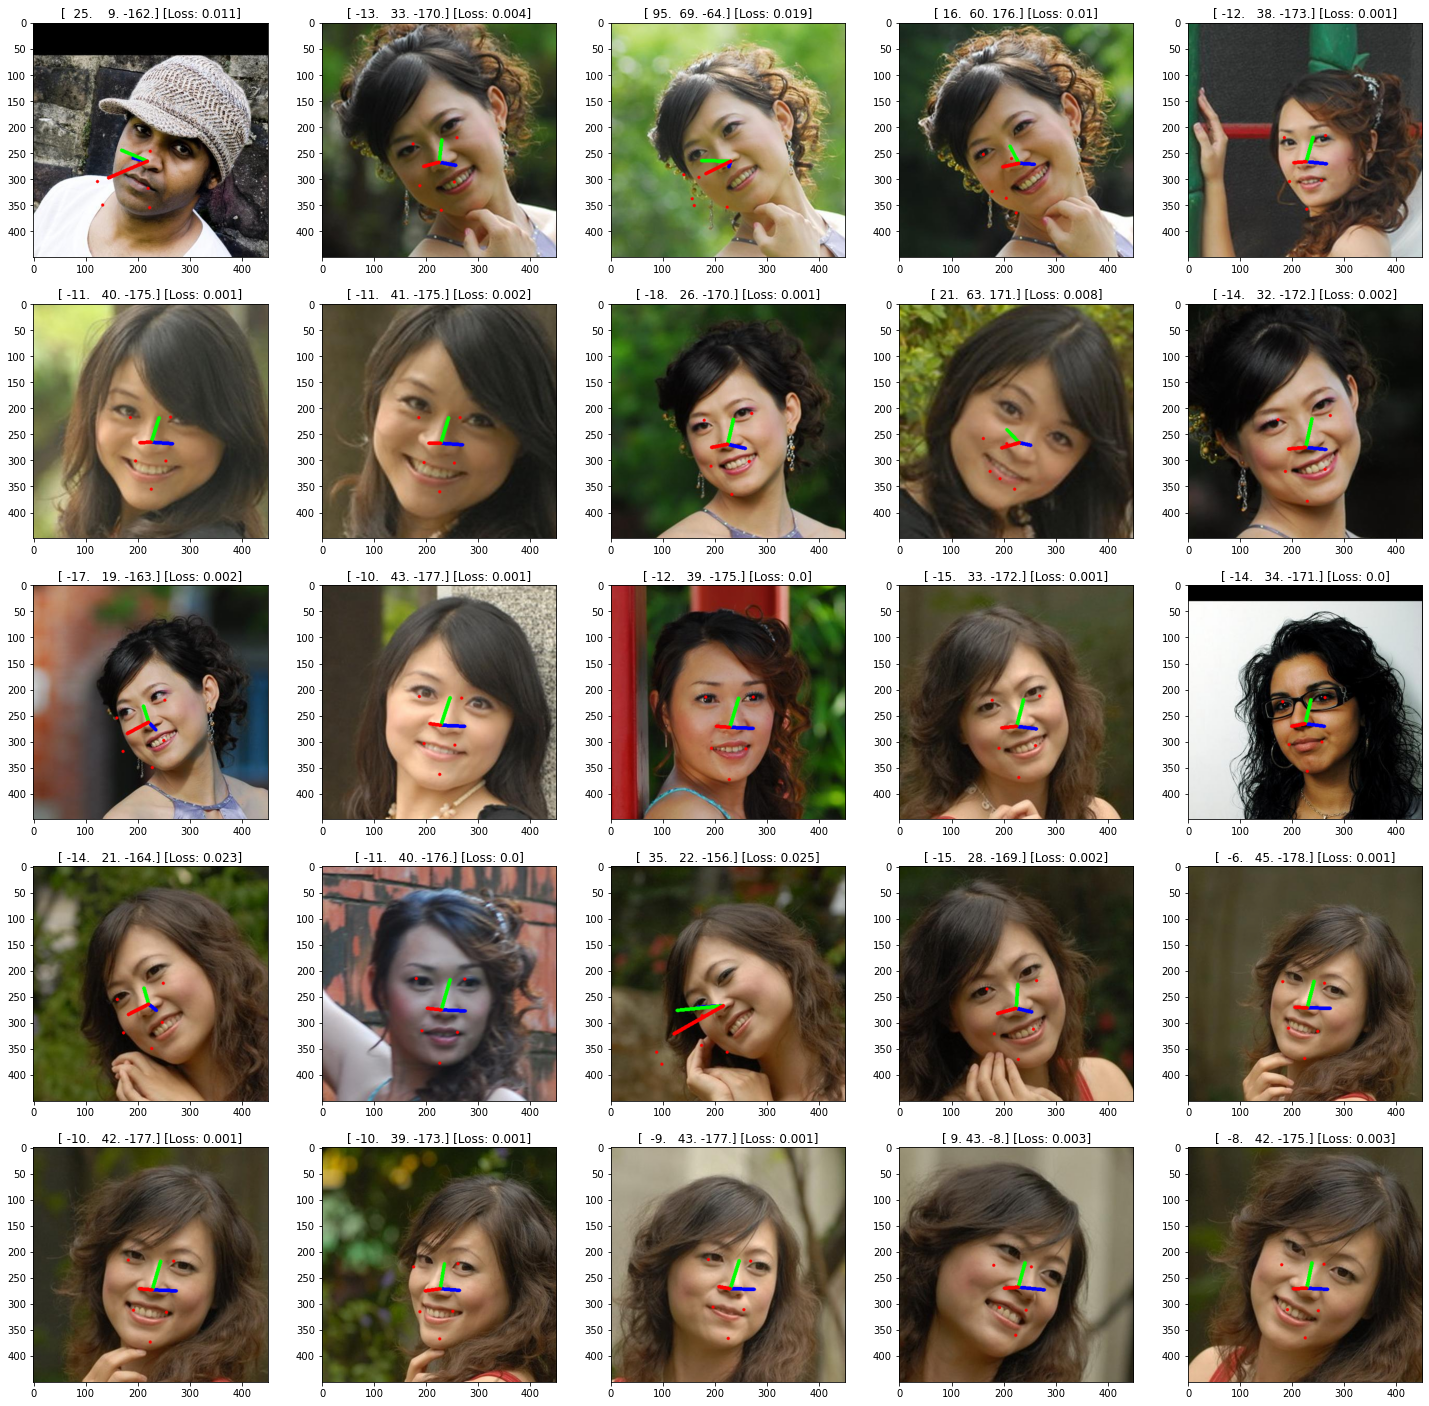

In [95]:
model = CNNModel()
model.load_state_dict(torch.load('model.pth'))
model.cuda()

loss_function = nn.MSELoss()

limit = 25

fig, ax = plt.subplots(5,5, figsize=(25, 25))


model.eval()
with torch.no_grad():
    global_test_loss = []
    for idx, batch in enumerate(test_dataloader):
        im, pts = batch[0].cuda(), batch[1].cuda()
        im = im.permute(0, 3, 1, 2)
        
        pts_out = model(im)
        
        loss = loss_function(pts_out, pts)
        
        global_test_loss.append(loss.item())
        
        out_image, rot_params = plotImage(im[0].permute(1, 2, 0).cpu(), pts_out[0].cpu())
        print(rot_params)
        
        if idx >= limit:
            break
        
        ax[idx//5,idx%5].set_title(str(np.round(rot_params)) + " " + "[Loss: {}]".format(round(loss.item(), 3)))
        ax[idx//5,idx%5].imshow(out_image)
        
        
        
    global_test_loss = np.mean(global_test_loss)

print(global_test_loss)

In [84]:

import cv2
import matplotlib.pyplot as plt
import signal

def signal_handler(signal, frame):
    # KeyboardInterrupt detected, exiting
    global is_interrupted
    is_interrupted = True

vc = cv2.VideoCapture(0)

plt.ion()

if vc.isOpened(): # try to get the first frame
    is_capturing, frame = vc.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
    webcam_preview = plt.imshow(frame)    
else:
    is_capturing = False
    print("Didn't open :(")

signal.signal(signal.SIGINT, signal_handler)
is_interrupted = False

while is_capturing:
    is_capturing, frame = vc.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
    webcam_preview.set_data(frame)
    plt.draw()

    try:    # Avoids a NotImplementedError caused by `plt.pause`
        plt.pause(0.05)
    except Exception:
        pass
    if is_interrupted:
        vc.release()
        break

Didn't open :(
